In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.speedup import calculate_speedups

%load_ext autoreload
%autoreload 2

sns.set_theme()

## Read data

In [2]:
threads = 64
sleeping_thresholds = [10, 20000]
types = ['binded', 'unbinded']

df = None

for i in range(1, threads + 1):
    for st in sleeping_thresholds:
        for bind_type in types:
            filename = '28-06-2022/speedup-{}-{}-threads-{}-us.csv'.format(bind_type, i, st)

            new_data = pd.read_csv(filename)
            new_data['threads'] = i
            new_data['sleeping_threshold'] = st
            new_data['type'] = bind_type
            new_data['branch'] = '{}-{}-us'.format(bind_type, st)

            df = pd.concat([df, new_data], ignore_index = True)

df.head()

,name,machine_id,threads,cpu_time_us,wall_clock_time_us,package_energy,core_energy,sleeping_threshold,type,branch
0,Life - sequential generation,dahu-9.grenoble.grid5000.fr,1,149784,149809,11425203,1120710,10,binded,binded-10-us
1,Life - sequential generation,dahu-9.grenoble.grid5000.fr,1,149442,149493,11360078,1112493,10,binded,binded-10-us
2,Life - sequential generation,dahu-9.grenoble.grid5000.fr,1,150283,150305,11432771,1121428,10,binded,binded-10-us
3,Life - sequential generation,dahu-9.grenoble.grid5000.fr,1,149821,149846,11435151,1123433,10,binded,binded-10-us
4,Life - sequential generation,dahu-9.grenoble.grid5000.fr,1,149347,149368,11352693,1115446,10,binded,binded-10-us


## Plot speedups

Text(32, 1, 'threads = 32')

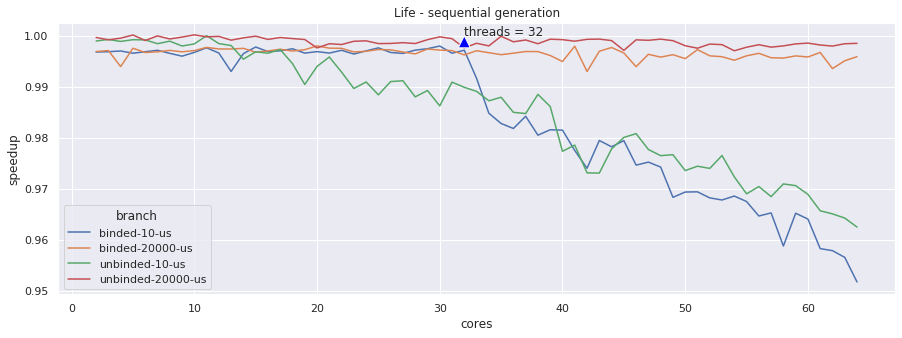

In [3]:
speedups = calculate_speedups(df)
speedups_df = pd.DataFrame(data=speedups)

fig, ax = plt.subplots(1, figsize=(15, 5))
sns.lineplot(x='cores', y='speedup', hue='branch', data=speedups_df);

ax.set_title(speedups['name'][0])

ax.annotate('threads = {}'.format(32), \
                xy=(32, 1), xycoords='data', \
                xytext=(32, 1), textcoords='data', \
                arrowprops=dict(facecolor='blue', shrink=0.05))

## Conclusion

Those experiments were performed using a fixed frequency of 2.1GHz for each core with idle states disabled. We did them because even in the fixed frequency scenario, we noticed that there was still a speedup decrease of around 5% for sequential algorithms. We had two hypotheses:

1. The speedup decrease is caused by excessive context-switching when the number of threads increase.
2. The speedup decrease is related to the sleeping threshold value. 

To test the first hyphotheses, we performed experiments with and without threads binded to a core, which should avoid context switching. 

To test the second one, we ran experiments using a sleeping threshold of 10 us (which is way too small compared to the scheduler quantum) and 20 ms (which is reasonable).

Looking at the data, we can see that the sleeping threshold has a bigger impact on the speedup curve than binding threads to specific cores. We can see in the graph that both the red (binded, 10 us) and the blue (unbinded, 10 us) lines lose more than 3% of speedups when using 60 threads. The orange (binded, 20000) and green (unbinded, 20000) lines have speedups close to 1 the whole time.

Also, the experiment was perform using a 32 cores processor with 64 threads. That could explain why the red line (binded, 10 us) starts to fall drastically when more than 32 threads are used. We could further investigate it at another moment, but for the moment, we have to decide if we will be using 32 threads for the following experiments and if we will use binded/unbinded threads. 